In [ ]:
import sys
import os

# Get the absolute path to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from chatbot_api.providers.openai import OpenAIProvider
from chatbot_api.base import EmbeddingResponse, Message, Role
from dotenv import load_dotenv
from pathlib import Path

# Load environment variables
env_path = Path.cwd().parent / ".env"  # move up one directory to find the .env file
success = load_dotenv(dotenv_path=env_path, override=True)
key = os.getenv("OPENAI_API_KEY")

# config
n_clusters = 5
n_comments = 50
response_max_tokens = 100
data_source_path = os.path.join(parent_dir, 'data', 'sources', 'kuntavaalit2021.csv')
plot_output_path = os.path.join('results', 'cluster_plot.png')
question_columns = ['q1.explanation_fi', 'q2.explanation_fi']
provider = OpenAIProvider(api_key=os.getenv("OPENAI_API_KEY"))

In [3]:

# Load the open comments from CSV
def load_statements(file_path: str) -> List[str]:
    df = pd.read_csv(file_path)
    return df[question_columns[1]].dropna()[:n_comments].tolist()

# Get embeddings for the political statements
async def get_embeddings_for_statements(statements: List[str]) -> List[EmbeddingResponse]:
    embeddings_responses = await provider.get_embeddings(statements)
    print(embeddings_responses[:10])
    return embeddings_responses

# Perform clustering based on embeddings
def cluster_messages(statements: List[str], embeddings_responses: List[EmbeddingResponse], n_clusters: int = 6):
    embeddings = np.array([response.embedding for response in embeddings_responses])
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    # Group statements by their cluster label
    clustered_statements = {i: [] for i in range(n_clusters)}
    for idx, label in enumerate(labels):
        clustered_statements[label].append(statements[idx])
    
    return clustered_statements, labels, embeddings

In [4]:
# Generate a summary for each cluster
async def summarize_cluster(statements: List[str]) -> str:
    prompt = (
        "The following are arguments from a cluster. Summarize them into a single representative statement:\n\n" +
        "\n".join(f"- {s}" for s in statements) +
        "\n\nSummarize these in one concise statement, distilling the essential message in the way that it is relevant to political decisions:"
    )
    
    messages = [Message(role=Role("user"), content=prompt)]
    response = await provider.generate(messages, temperature=0.7, max_tokens=response_max_tokens)
    return response.content

# Visualize the clusters
def visualize_clusters(embeddings: np.ndarray, labels: np.ndarray, n_clusters: int):
    # Reduce dimensionality to 2D using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Create a DataFrame for easy plotting
    cluster_df = pd.DataFrame({
        'x': reduced_embeddings[:, 0],
        'y': reduced_embeddings[:, 1],
        'cluster': labels
    })
    
    # Plot clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=cluster_df,
        x='x', y='y',
        hue='cluster',
        palette=sns.color_palette('hsv', n_clusters),
        legend='full'
    )
    plt.title('Clusters of Political Statements (2D Visualization)')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.legend(title='Cluster')
    plt.show(block=False)
    # Save plot to a file
    plt.savefig(plot_output_path, dpi=300)
    print(f"Cluster visualization saved to {plot_output_path}")

def display_cluster_details(clustered_messages: dict, cluster_summaries: dict):
    """
    Display the original statements for each cluster alongside their summary.
    
    Args:
        clustered_messages (dict): Dictionary mapping cluster IDs to lists of original statements
        cluster_summaries (dict): Dictionary mapping cluster IDs to cluster summaries
    """
    for cluster_id in sorted(clustered_messages.keys()):
        print(f"\n{'='*80}")
        print(f"Cluster {cluster_id}")
        print(f"{'='*80}")
        
        # Print the summary
        print("\nCluster Summary:")
        print(f"{cluster_summaries[cluster_id]}")
        
        # Print all original statements
        print("\nOriginal Statements:")
        for idx, statement in enumerate(clustered_messages[cluster_id], 1):
            print(f"\n{idx}. {statement}")
        
        print(f"\nTotal statements in cluster: {len(clustered_messages[cluster_id])}")
        print(f"{'='*80}\n")

[EmbeddingResponse(embedding=array([0.01530454, 0.03132883, 0.03368799, ..., 0.02379151, 0.01400501,
       0.00734238], dtype=float32), tokens=78, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([-0.05042229,  0.04227563,  0.04488572, ...,  0.01745007,
        0.01290217,  0.00590237], dtype=float32), tokens=78, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([ 0.00405296,  0.01261031,  0.09072276, ..., -0.00351719,
        0.00770905,  0.04702821], dtype=float32), tokens=78, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([ 0.01266587,  0.02570185,  0.0730755 , ..., -0.02115776,
        0.01489679,  0.03287781], dtype=float32), tokens=78, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([ 0.01444087,  0.05034326,  0.05403433, ...,  0.00108211,
       -0.00617399,  0.01091151], dtype=float32), tokens=78, model='text-embedding-3-small'), EmbeddingResponse(embedding=array([-0.0618645 ,  0.02142385, -0.02034558, .

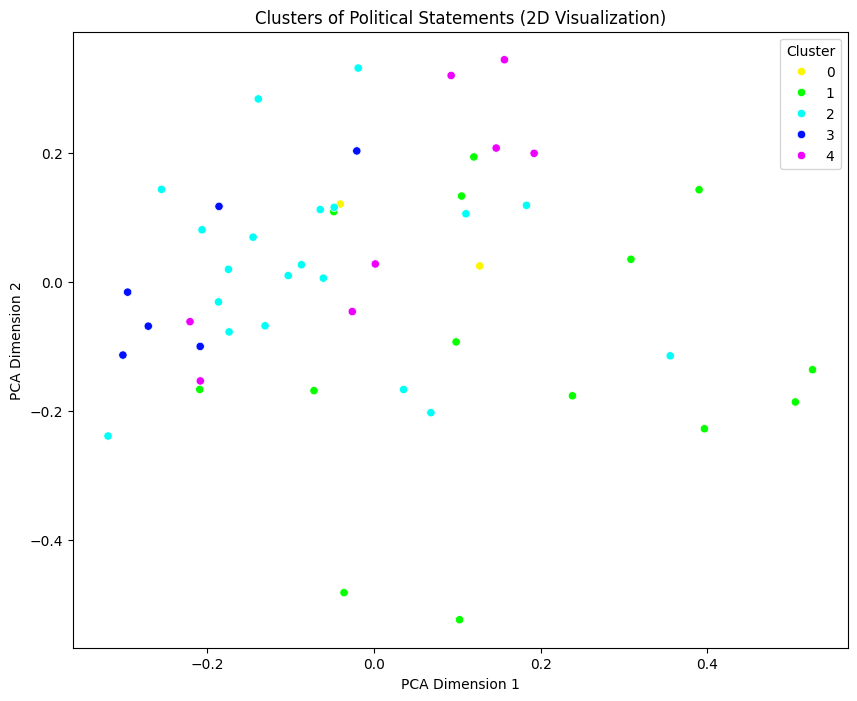

/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/ast.py:50: RuntimeWarning: coroutine 'main' was never awaited
  return compile(source, filename, mode, flags,


FileNotFoundError: [Errno 2] No such file or directory: '/Users/max/projects/learning/aalto/openvaa/argument-condensation/data/results/cluster_plot.png'

<Figure size 640x480 with 0 Axes>

In [8]:
async def main():
    # Load the statements from CSV
    statements = load_statements(data_source_path)
    
    # Get embeddings for each statement
    embeddings_responses = await get_embeddings_for_statements(statements)

    # Cluster the statements based on their embeddings
    clustered_messages, labels, embeddings = cluster_messages(statements, embeddings_responses, n_clusters=n_clusters)

    # Generate summaries for each cluster
    cluster_summaries = {}
    for cluster_id, cluster_statements in clustered_messages.items():
        print(f"Summarizing Cluster {cluster_id}...")
        cluster_summaries[cluster_id] = await summarize_cluster(cluster_statements)
    
    # Print clustered summaries
    for cluster_id, summary in cluster_summaries.items():
        print(f"Cluster {cluster_id} Summary:")
        print(summary)
        print()

    # Visualize
    print("Visualizing clusters...")
    visualize_clusters(embeddings, labels, n_clusters=n_clusters)

# Run the script
await main()